# Data Preprocessing

Throughout the process of model training, data preprocessing is one of the most important steps that could heavily affect the model performance. The data preprocessing methods include but not limited to removing/replacing the NaN (Not a Number) or NULL data, integer-encoding the class labels and scaling the features.

In this notes, I will go through dealing with several data, splitting the dataset, scaling the features, implementing feature selection and utilizing random forest.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Dealing with data

1. Removing/replacing NaN or NULL data
2. Integer encoding categorical data
3. One-hot encoding non-ordered data

In [2]:
from io import StringIO

csv_data = '''
A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
9.0,10.0,11.0,
'''
nan_df = pd.read_csv(StringIO(csv_data)) # StringIO enables to change string to .csv format
nan_df.head()

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,9.0,10.0,11.0,NaN


```DataFrame.isna().sum()``` counts the number of NaN data in the dataset.

In [3]:
nan_df.isna().sum()

A    0
B    0
C    1
D    1
dtype: int64

```DataFrame.dropna()``` drops rows (when parameter 'axis' is 0) or columns (when parameter 'axis' is 1) that contain NaN data in the dataset.

In [4]:
drop_row = nan_df.dropna(axis=0)
print('Drop row:\n', drop_row)

drop_col = nan_df.dropna(axis=1)
print('Drop column:\n', drop_col)

Drop row:
      A    B    C    D
0  1.0  2.0  3.0  4.0
Drop column:
      A     B
0  1.0   2.0
1  5.0   6.0
2  9.0  10.0


Dropping too many rows or columns is not recommended, since it may cause the dataset to become less informative. Instead, the **interpolation** method can take into account to assign the new value for NaN data based on the strategies (e.g mean, median and most frequent) you are willing to define.

In [5]:
from sklearn.impute import SimpleImputer

imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(nan_df.to_numpy())
imputed_data = imr.transform(nan_df.to_numpy())
print(imputed_data)

[[ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]
 [ 9. 10. 11.  6.]]


Interpolation can also be done by using ```Dataframe.fillna()``` and ```Dataframe.mean()``` as well.

In [6]:
nan_df.fillna(nan_df.mean())

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,7.0,8.0
2,9.0,10.0,11.0,6.0


In [7]:
cate_df = pd.DataFrame([
    ['green', 'M', 10.9, 'class_1'],
    ['blue', 'L', 14.9, 'class_2'],
    ['gray', 'S', 9.9, 'class_2'],
    ['red', 'XL', 19.9, 'class_1']
])
cate_df.columns = ['color', 'size', 'price', 'label']
cate_df.head()

,color,size,price,label
0,green,M,10.9,class_1
1,blue,L,14.9,class_2
2,gray,S,9.9,class_2
3,red,XL,19.9,class_1


Feature size encoding using a dictionary *size_mapping*.

In [8]:
size_mapping = {'XL': 4, 'L': 3, 'M': 2, 'S': 1}
cate_df['size'] = cate_df['size'].map(size_mapping)
cate_df.head()

,color,size,price,label
0,green,2,10.9,class_1
1,blue,3,14.9,class_2
2,gray,1,9.9,class_2
3,red,4,19.9,class_1


Class label encoding using a dictionary *class_mapping*.

In [9]:
class_mapping = {label: idx for idx, label in enumerate(np.unique(cate_df['label']))}
cate_df['label'] = cate_df['label'].map(class_mapping)
cate_df.head()

,color,size,price,label
0,green,2,10.9,0
1,blue,3,14.9,1
2,gray,1,9.9,1
3,red,4,19.9,0


It is always a good practice to have integer-encoded class labels. In most cases, you can simply use ```sklearn.preprocessing.LabelEncoder``` class to encode the class labels to integers.

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
cate_df['label'] = le.fit_transform(cate_df['label'])
cate_df.head()

,color,size,price,label
0,green,2,10.9,0
1,blue,3,14.9,1
2,gray,1,9.9,1
3,red,4,19.9,0


If there are features without the sequential order like 'color', you can do **one-hot encoding** using ```pandas.get_dummies()```. If parameter 'drop_first' is **true**, it will drop the first one-hot encoding column.

In [11]:
pd.get_dummies(cate_df, drop_first=True)

,size,price,label,color_gray,color_green,color_red
0,2,10.9,0,0,1,0
1,3,14.9,1,0,0,0
2,1,9.9,1,1,0,0
3,4,19.9,0,0,0,1


## Splitting the dataset

Load the wine dataset from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data) or [data](./data/) folder. Always remind to split the dataset into two separate parts like the training and testing dataset.

In [12]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['label', 'alcohol', 'malic acid', 'ash', 'alcalinity of ash', 'magnesium', 'total phenols',
                  'flavanoids', 'nonflavanoid phenols', 'proanthocyanins', 'color intensity', 'hue',
                   '0D280/0D315 of diluted wines', 'proline']
df_wine.head()

,label,alcohol,malic acid,ash,alcalinity of ash,magnesium,total phenols,flavanoids,nonflavanoid phenols,proanthocyanins,color intensity,hue,0D280/0D315 of diluted wines,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [13]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].to_numpy(), df_wine.iloc[:, 0].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

## Scaling the features

The two most well-known feature scaling methods are **normalization** and **standardization**.

In [14]:
arr = np.array([0, 1, 2, 3, 4, 5])
normal = (arr - arr.min()) / (arr.max() - arr.min())
standard = (arr - arr.mean()) / arr.std()
df = pd.DataFrame(
    np.hstack((arr[:, np.newaxis], normal[:, np.newaxis], standard[:, np.newaxis])),
    columns=['Input', 'Normalization', 'Standardization']
)
print(df)

   Input  Normalization  Standardization
0    0.0            0.0         -1.46385
1    1.0            0.2         -0.87831
2    2.0            0.4         -0.29277
3    3.0            0.6          0.29277
4    4.0            0.8          0.87831
5    5.0            1.0          1.46385


Normalization using ```sklearn.preprocessing.MinMaxScaler```.

In [15]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
X_train_mms = mms.fit_transform(X_train)
X_test_mms = mms.transform(X_test)

Standardization using ```sklearn.preprocessing.StandardScaler```.

In [16]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train_std = ss.fit_transform(X_train)
X_test_std = ss.transform(X_test)

## Implementing feature selection

**Feature selection** (or, **dimensionality reduction**) is a method to prevent the overfitting and reduce the complexity of the model. **Sequential feature selection** is a greedy search algorithm that finds important feature subsets among the entire features to remove the unnecessary noises and increase model's computational efficiency. As a result, the algorithm transforms the dataset from initial $d$-dimensional space to smaller $k$-dimensional space where $k << d$.

In [17]:
from itertools import combinations
from sklearn.base import clone
from sklearn.metrics import accuracy_score

class SBS():
    # Sequential Backward Selection (SBS)
    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.25, random_state=1):
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.scoring = scoring
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self.calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r=dim-1):
                score = self.calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            
            best = np.argmax(scores)
            self.scores_.append(scores[best])
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
        
        return self
        
    def calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score
    
    def transform(self, X):
        return X[:, self.indices_]

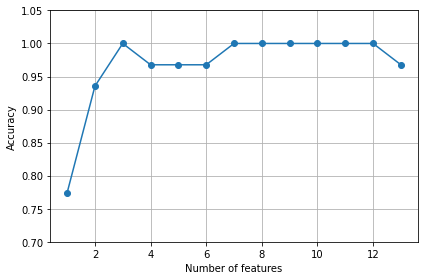

In [18]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

sbs = SBS(estimator=knn, k_features=1)
sbs.fit(X_train_std, y_train)

num_features = [len(k) for k in sbs.subsets_[::-1]]
plt.plot(num_features, list(reversed(sbs.scores_)), marker='o')
plt.ylim([0.7, 1.05])
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.grid()
plt.tight_layout()
plt.show()

In [19]:
# number of features = 3
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

Index(['alcohol', 'malic acid', '0D280/0D315 of diluted wines'], dtype='object')


Evaluate KNN classifier using **entire 13 features**.

In [20]:
knn.fit(X_train_std, y_train)
print('Train accuracy: {:.3f}'.format(knn.score(X_train_std, y_train)))
print('Test accuracy: {:.3f}'.format(knn.score(X_test_std, y_test)))

Train accuracy: 0.968
Test accuracy: 0.963


Evaluate KNN classifier using only **3 features** that are selected using SBS algorithm. As a result, the test accuarcy is slightly decreased but indicates that those features contain the most important information in the dataset.

In [21]:
knn.fit(X_train_std[:, k3], y_train)
print('Train accuracy: {:.3f}'.format(knn.score(X_train_std[:, k3], y_train)))
print('Test accuracy: {:.3f}'.format(knn.score(X_test_std[:, k3], y_test)))

Train accuracy: 0.952
Test accuracy: 0.926


## Utilizing random forest algorithm

Random forest, an ensemble algorithm, is another useful feature selection method to choose features with high importance.

In [22]:
from sklearn.ensemble import RandomForestClassifier

features = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = list(reversed(np.argsort(importances)))

for i in range(X_train.shape[1]):
    print(f'{i+1: >2}) {features[indices[i]]: <30} {importances[indices[i]]}')

 1) proline                        0.18545260453273973
 2) flavanoids                     0.17475097557788732
 3) color intensity                0.14391990337231414
 4) 0D280/0D315 of diluted wines   0.1361619442214559
 5) alcohol                        0.11852941731789315
 6) hue                            0.05873899628096849
 7) total phenols                  0.05087242613744542
 8) magnesium                      0.03135708460816904
 9) malic acid                     0.025648355564265708
10) proanthocyanins                0.02556987901932914
11) alcalinity of ash              0.0223659419376885
12) nonflavanoid phenols           0.013353928195970421
13) ash                            0.013278543233872913


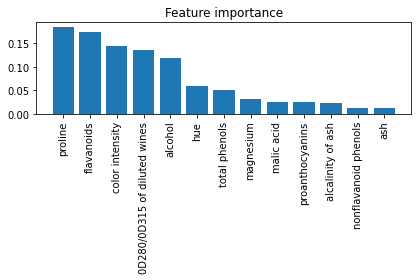

In [23]:
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.title('Feature importance')
plt.xticks(range(X_train.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()